In [43]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

torch.manual_seed(42)

transform = T.Compose([
    T.ToTensor(),           # converts image pixels to tensor
    T.Normalize([0.5], 0.5) # normalizes the values to the range [-1, 1]
])

In [44]:
train_set = torchvision.datasets.FashionMNIST(
    root=".",
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.FashionMNIST(
    root=".",
    train=False,
    download=True,
    transform=transform
)

In [45]:
text_labels=['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

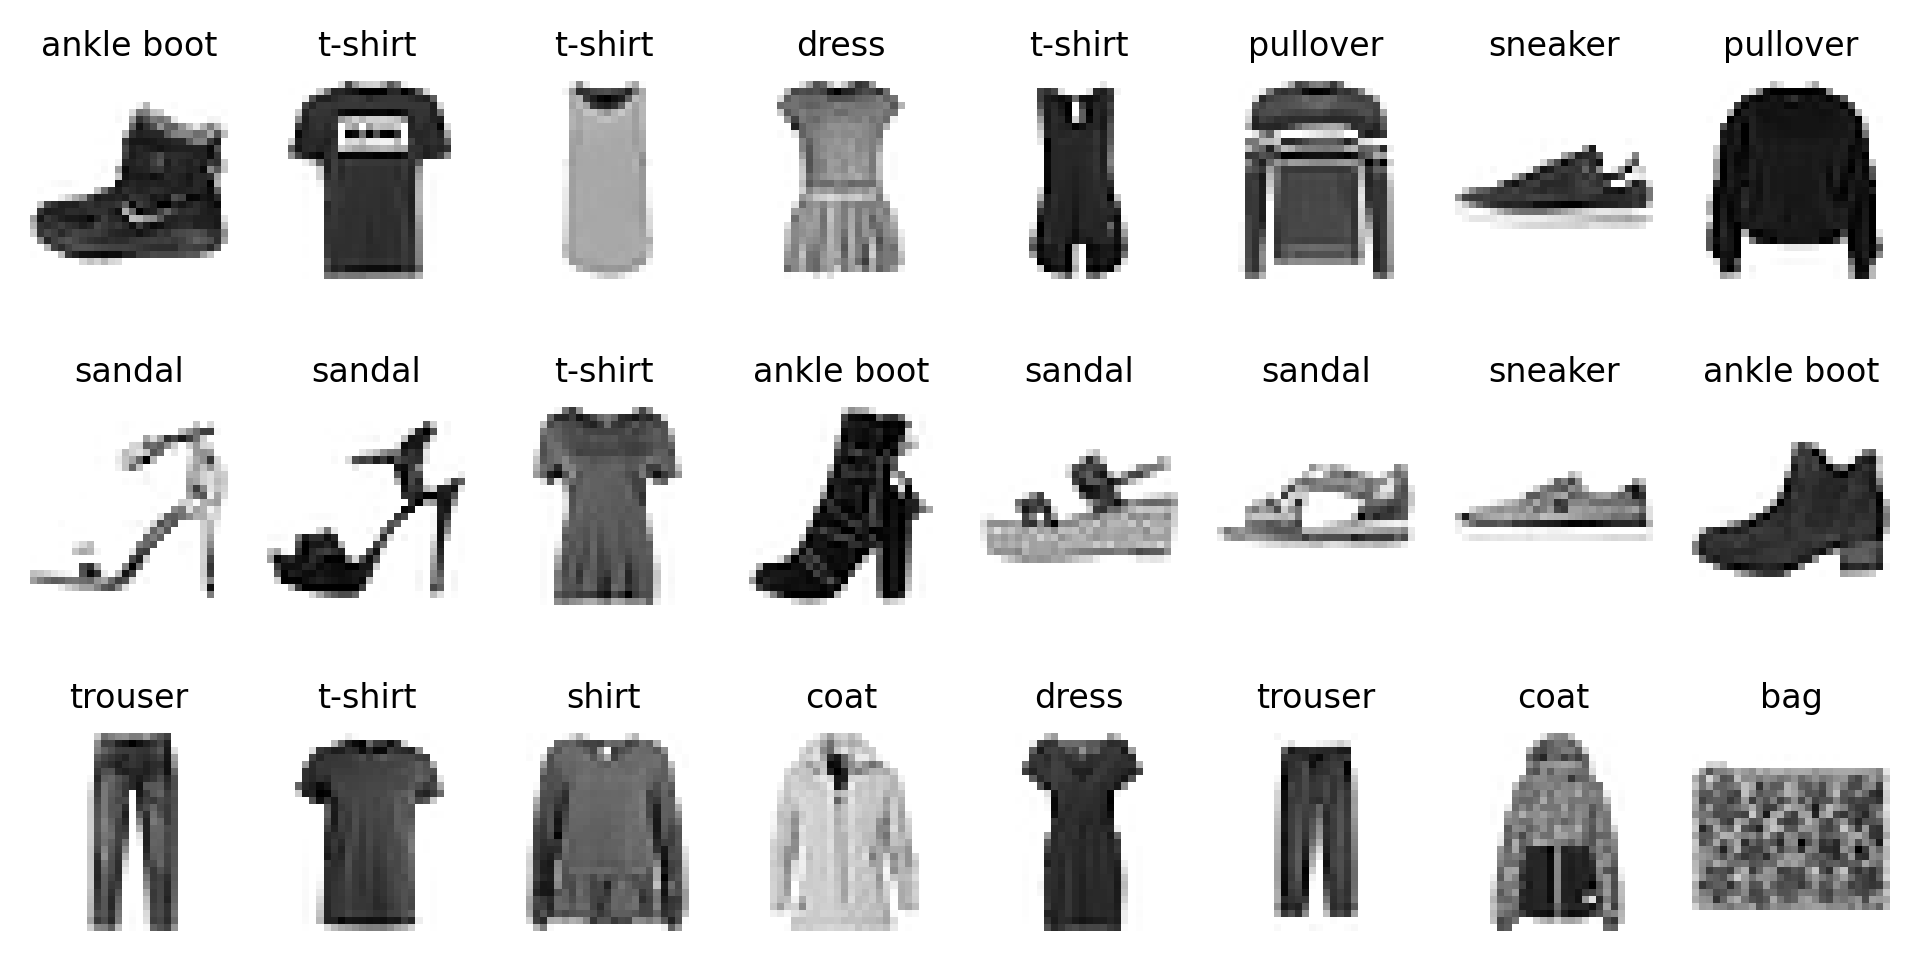

In [46]:
import matplotlib.pyplot as plt

plt.figure(dpi=300,figsize=(8,4))
for i in range(24):
    ax=plt.subplot(3, 8, i + 1)
    img=train_set[i][0]
    img=img/2+0.5
    img=img.reshape(28, 28)
    plt.imshow(img, cmap="binary")
    plt.axis('off')
    plt.title(text_labels[train_set[i][1]], fontsize=8)
plt.show()

In [47]:
# only t-shirts and ankle boots
binary_train_set=[x for x in train_set if x[1] in [0,9]]
binary_test_set=[x for x in test_set if x[1] in [0,9]]

In [48]:
# creating batches for training and testing
batch_size = 64

binary_train_loader = torch.utils.data.DataLoader(
    binary_train_set,
    batch_size=batch_size,
    shuffle=True
)

binary_test_loader = torch.utils.data.DataLoader(
    binary_test_set,
    batch_size=batch_size,
    shuffle=True
)

In [49]:
# creating a binary classification model
device = "cuda" if torch.cuda.is_available() else "cpu"

binary_model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Dropout(p=0.25),
    nn.Sigmoid()
).to(device)

In [50]:
# define learning, optimizer (Adam) and loss function (Binary Cross Entropy )
lr = 0.001
optimizer = torch.optim.Adam(binary_model.parameters(),lr=lr)
loss_fn = nn.BCELoss()
epochs = 50

In [ ]:
# training loop
for i in range(epochs):
    tloss = 0
    for imgs, labels in binary_train_loader:                           # iterates through all batches
        imgs = imgs.reshape(-1, 28*28)                                 # flattens the image before moving the tensor to device
        imgs = imgs.to(device)
        labels = torch.FloatTensor([x if x==0 else 1 for x in labels]) # converts labels to 0 and 1
        labels = labels.reshape(-1, 1).to(device)

        preds = binary_model(imgs)
        loss = loss_fn(preds, labels)                                   # calculates the loss
        optimizer.zero_grad() 
        loss.backward()                                                # backpropagation
        optimizer.step()

        tloss += loss.detach().cpu().item()                            # accumulate loss (moved to CPU)

    tloss = tloss / len(binary_train_loader)                           # average loss per batch

    if i == 0 or (i + 1) % 10 == 0:
        print(f"Epoch {i + 1}, Loss: {tloss}")

Epoch 1, Loss: 0.1905444618710812
Epoch 10, Loss: 0.1748502985673382
Epoch 20, Loss: 0.17023633170793664
Epoch 30, Loss: 0.17161675930974332
Epoch 40, Loss: 0.1743238915075013
Epoch 50, Loss: 0.17576400674086937


In [ ]:
# calculates the accuracy of the predictions
import numpy as np

results = []
for imgs,labels in binary_test_loader:
    imgs = imgs.reshape(-1,28*28).to(device)
    labels = (labels/9).reshape(-1,1).to(device)
    preds = binary_model(imgs)
    pred10 = torch.where(preds>0.5,1,0)
    correct = (pred10 == labels)
    results.append(correct.detach().cpu().numpy().mean())
    accuracy = np.array(results).mean()

print(f"the accuracy of the predictions is {accuracy}")

the accuracy of the predictions is 0.87548828125
